In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import combinations

# List of stock symbols for demonstration purposes
symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NFLX']
data = yf.download(symbols, start="2014-01-01", end="2024-01-01")['Adj Close']
data.head()

[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,MSFT,NFLX
Date,,,,,
2014-01-02 00:00:00+00:00,17.253256,19.898500,27.787050,31.120745,51.831429
2014-01-03 00:00:00+00:00,16.874279,19.822001,27.584349,30.911366,51.871429
2014-01-06 00:00:00+00:00,16.966291,19.681499,27.891897,30.258129,51.367142
2014-01-07 00:00:00+00:00,16.844954,19.901501,28.429604,30.492628,48.500000
2014-01-08 00:00:00+00:00,16.951630,20.096001,28.488766,29.948263,48.712856


In [77]:
# Define the slice intervals
slice_interval = pd.DateOffset(months=18)  # 18 months (12 + 6)

# List to hold the slices
slices = []

# Start slicing the data
start_date = data.index[0]  # Start from the beginning of the data

while start_date < data.index[-1]:  # Loop until the start date is less than the last date
    # Calculate the end date for the current slice
    end_date = start_date + slice_interval

    # Create a slice of data from start_date to end_date
    slice_data = data.loc[start_date:end_date]
    slices.append(slice_data)
    
    # Move the window forward by 18 months
    start_date += slice_interval
    

In [6]:
# Calculate pairwise Euclidean distances
def euclidean_distance(series1, series2):
    return np.sqrt(np.sum((series1 - series2) ** 2))


# Find the best k pairs
def get_best_pairs(normalised_data: pd.DataFrame, k: int = 3):
    pairs = combinations(normalised_data.columns, 2)
    pair_distances = {
        (stock1, stock2): euclidean_distance(
            normalised_data[stock1], 
            normalised_data[stock2],
        ) 
        for stock1, stock2 in pairs
    }
    best_pairs = []
    for _ in range(k):
        _pair = min(pair_distances, key=pair_distances.get)
        pair_distances.pop(_pair, None)
        best_pairs.append(_pair)
    return best_pairs



For each slice take the first 12 months as a formation period to compute the 
long-running mean and standard deviation of the time series and compute the 
best pairs for this period.

In [7]:
# for now let us use 1 slice - the logic is easily extensible to all slices
stock_prices = slices[0]

# Normalise the data by dividing by the first value (as in the original paper) 
# Note: There various other methods to standardise stock prices in this 
# scenario
normalised_data = stock_prices / stock_prices.iloc[0]

# use 12 months for formation and 6 months for trading (test) period
start_date = normalised_data.index[0]
date_diff = pd.DateOffset(months=12)

train_data = normalised_data[start_date:start_date+date_diff]
test_data = normalised_data[start_date+date_diff:]

# get best pairs based on formation data
best_pairs = get_best_pairs(train_data, k=3)

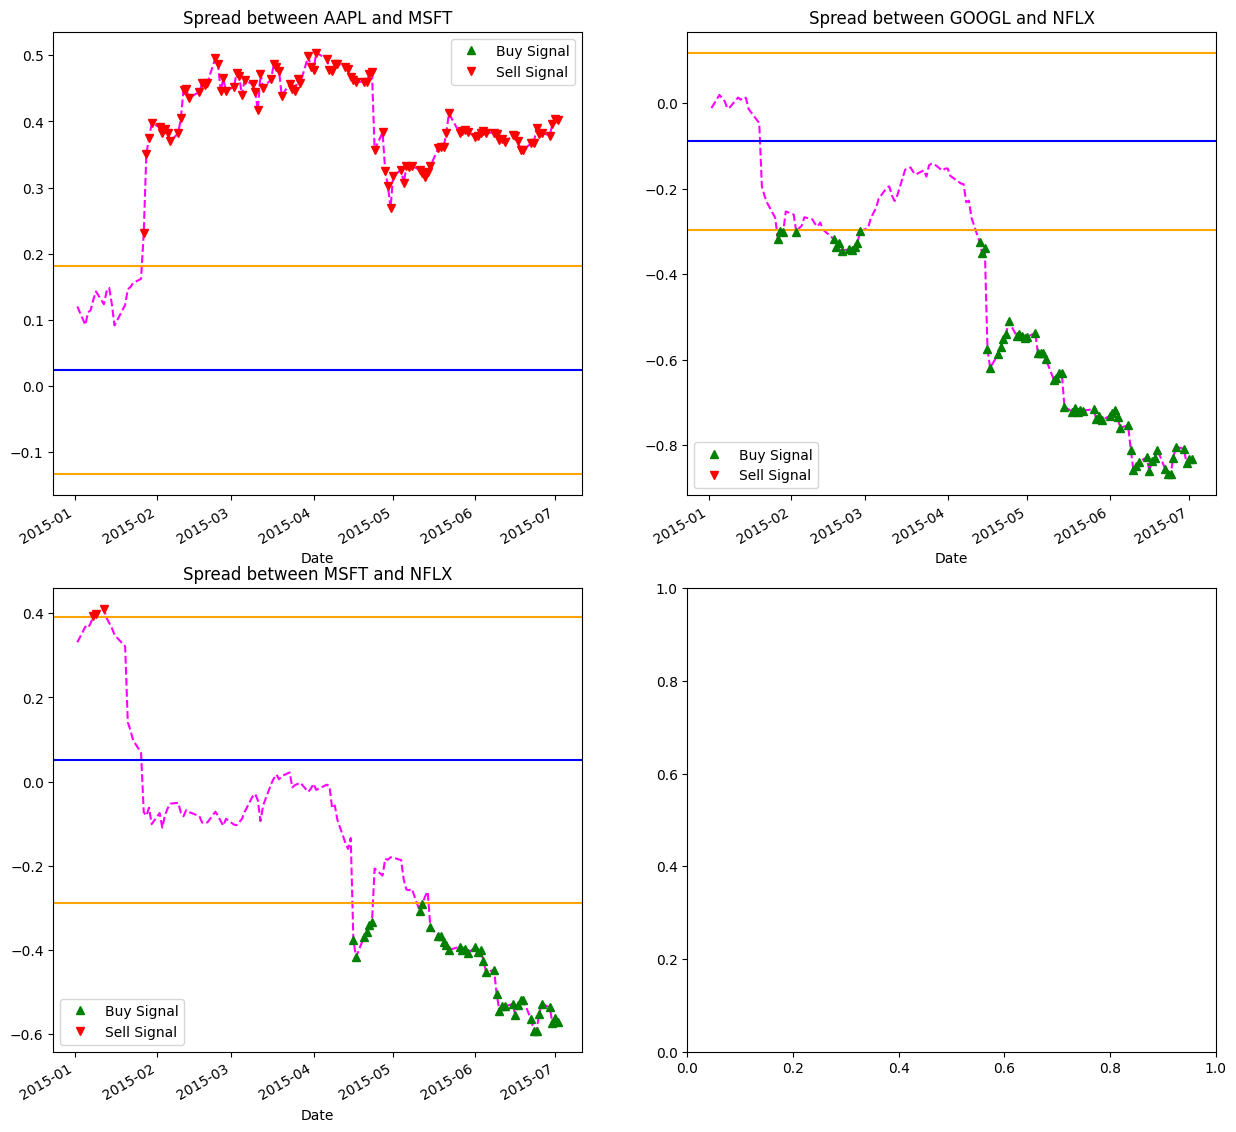

In [19]:
pairs_data = {}

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

for i, (stock0, stock1) in enumerate(best_pairs):
    # Calculate mean / std for formation period
    spread_train = train_data[stock0] - train_data[stock1]
    m = spread_train.mean()
    s = spread_train.std()
    
    # Calculate the mean for the actual trading period
    spread = test_data[stock0] - test_data[stock1]
    
    signal = pd.Series(0, index=spread.index)
    buy_signal = spread.apply(lambda x: True if x < m - 2 * s else False)
    sell_signal = spread.apply(lambda x: True if x > m + 2 * s else False)

    pairs_data[(stock0, stock1)] = {
        'spread': spread,
        'mean': m, 
        'std': s, 
        'buy_signal': buy_signal, 
        'sell_signal': sell_signal
    }
    
    # Plot the spread on the corresponding subplot
    row, col = i // 2, i % 2  #
    spread.plot(ax=axes[row, col], color='magenta', ls='--')
    axes[row, col].axhline(m, color='blue')
    axes[row, col].axhline(m - 2 * s, color='orange')
    axes[row, col].axhline(m + 2 * s, color='orange')
    axes[row, col].set_title(f"Spread between {stock0} and {stock1}")
    
    # Plot up arrows for buy signals
    axes[row, col].plot(
        spread[buy_signal].index, 
        spread[buy_signal],
        marker='^', color='green', linestyle='None', label='Buy Signal'
    )
    
    # Plot down arrows for sell signals
    axes[row, col].plot(
        spread[sell_signal].index,
        spread[sell_signal],
        marker='v', color='red', linestyle='None', label='Sell Signal'
    )
    
    # Add a legend if needed
    axes[row, col].legend()
    
plt.show()

In [53]:
df_test = pd.DataFrame(pairs_data[best_pairs[0]])
df_test.index.max()

Timestamp('2015-07-02 00:00:00+0000', tz='UTC')

In [55]:
# now the actual trades
for pair in best_pairs:
    
    df_test = pd.DataFrame(pairs_data[pair])
    df_test['trade'] = 0
    df_test['trade_price'] = 0.0
    df_test['position'] = 0
    df_test['equity'] = 0.0
    portfolio = 0
    current_position = 0  # 0: no position, 1: long, -1: short
    
    for i, row in df_test.iterrows():
        if row['buy_signal'] and current_position == 0:
            df_test.at[i, 'trade'] = 1
            portfolio -= 1 * row['spread']
            current_position = 1  # Update position to long
    
        elif row['sell_signal'] and current_position == 0:
            df_test.at[i, 'trade'] = -1
            portfolio += 1 * row['spread']
            current_position = -1  # Update position to short
    
        elif (current_position == 1 
              and (row['spread'] >= row['mean'] or i == df_test.index.max())
        ):
            df_test.at[i, 'trade'] = -1
            portfolio += 1 * row['spread']
            current_position = 0  # flat
    
        elif (current_position == -1 
              and (row['spread'] <= row['mean'] or i == df_test.index.max())
        ):
            df_test.at[i, 'trade'] = 1
            portfolio -= 1 * row['spread']
            current_position = 0  # flat
        
        df_test.at[i, 'position'] = current_position
        df_test.at[i, 'equity'] = portfolio
    
    pairs_data[pair] = df_test


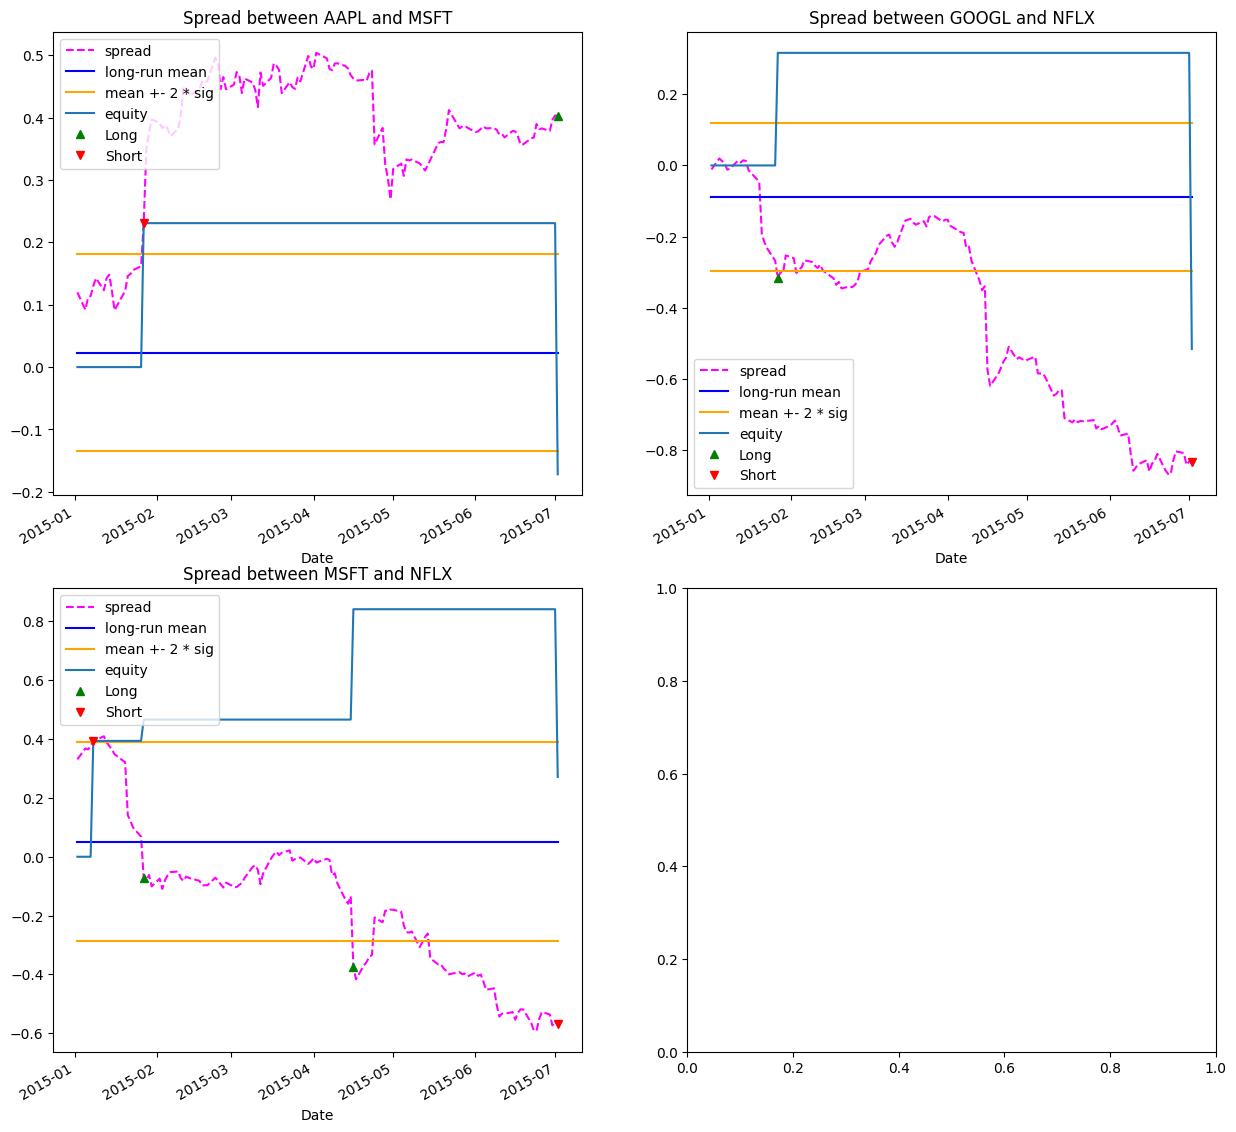

In [76]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for i, (pair, df) in enumerate(pairs_data.items()):
    stock0, stock1 = pair

    # Plot the spread on the corresponding subplot
    row, col = i // 2, i % 2  #
    df['spread'].plot(ax=axes[row, col], color='magenta', ls='--')
    axes[row, col].plot(df['mean'], color='blue', label='long-run mean')
    axes[row, col].plot(df['mean'] - 2 * df['std'], color='orange', 
                        label='mean +- 2 * sig')
    axes[row, col].plot(df['mean'] + 2 * df['std'], color='orange')
    axes[row, col].set_title(f"Spread between {stock0} and {stock1}")
    axes[row, col].plot(df['equity'],label='equity')
    buy_trades = df['trade'].apply(lambda x: True if x == 1 else False)
    sell_trades = df['trade'].apply(lambda x: True if x == -1 else False)

    # Plot up arrows for long trades
    axes[row, col].plot(
        df.index[buy_trades], 
        df['spread'][buy_trades],
        marker='^', color='green', linestyle='None', label='Long'
    )
    
    # Plot down arrows for short trades 
    axes[row, col].plot(
        df.index[sell_trades], 
        df['spread'][sell_trades],
        marker='v', color='red', linestyle='None', label='Short'
    )
    
    # Add a legend if needed
    axes[row, col].legend()
